## **Data Ingestion**

In [1]:
import sys
sys.path.append('../')

!pwd

/c/Users/Vladimir/Desktop/Everything/Work/ARLIS/development/incubator-flagon-distill/prototype_1


In [2]:
!ls

logs_alex.json
logs_amir.json
logs_liam.json
logs_vlad.json
model.pth
Prototype 1.ipynb


In [3]:
import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re

df = pd.read_json("logs_vlad.json")
df.head()

,target,path,clientTime,microTime,location,type,logType,userAction,details,userId,...,toolName,useraleVersion,sessionID,pageUrl,pageTitle,pageReferrer,browser,scrnRes,attributes,style
0,None,None,1682359431822,0.0,None,browser.tabs.onActivated,raw,True,"{'active': True, 'audible': False, 'incognito'...",nobody,...,None,None,session_1682359431117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,1682359435111,0.9,None,browser.tabs.onActivated,raw,True,"{'active': True, 'audible': False, 'incognito'...",nobody,...,None,None,session_1682359431117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,None,1682359436401,0.6,None,browser.tabs.onActivated,raw,True,"{'active': True, 'audible': False, 'incognito'...",nobody,...,None,None,session_1682359431117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,None,1682359452355,0.4,None,browser.tabs.onZoomChange,raw,True,"{'oldZoomFactor': 1, 'newZoomFactor': 1, 'acti...",nobody,...,None,None,session_1682359431117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1682359452944,NaN,NaN,load,custom,False,{'pageLoadTime': 28},nobody,...,test_app,2.3.0,session_1682359431117,http://localhost:8088/superset/dashboard/world...,World Bank's Data,,"{'browser': 'chrome', 'version': '112.0.0'}","{'width': 1384, 'height': 959}",{},{}


In [4]:
print(df.columns)
print( type(df['attributes']) )
print( type(df['attributes'].iloc[-1]) )
print( (df['attributes'].iloc[-1]['data-info']['name']) )

Index(['target', 'path', 'clientTime', 'microTime', 'location', 'type',
       'logType', 'userAction', 'details', 'userId', 'toolVersion', 'toolName',
       'useraleVersion', 'sessionID', 'pageUrl', 'pageTitle', 'pageReferrer',
       'browser', 'scrnRes', 'attributes', 'style'],
      dtype='object')
<class 'pandas.core.series.Series'>
<class 'dict'>
India


As we can see, the logs json produces a dataframe with a column that hold each web-interaction's (in this case, exclusively clicks') dictionary of attributes wherein the name of the clicked country is located

Now lets try extracting the relevant logs into list or Segment types. My initial method:

In [5]:
sessions = []
curr_session = []
for index, row in df.iterrows(): # for each row
    attr = row['attributes']
    # if the attributes column element is a dictionary and contains the data-info dictionary, append the click log
    if isinstance(attr, dict) and ('data-info' in attr):
        curr_session.append( row )
    # Otherwise, if the session is over, append the last session and reset for the new one
    elif len(curr_session)!=0:
        sessions.append(curr_session)
        curr_session = []
print("Final # of sessions: ", len(sessions))

Final # of sessions:  27


## Preprocessing

In [6]:
import sys
sys.path.append('../')

import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re

def setup(file, date_type):
    with open(file) as json_file:
        raw_data = json.load(json_file)

    data = {}
    for log in raw_data:
        data[distill.getUUID(log)] = log
        
    # Convert clientTime to specified type
    for uid in data:
        log = data[uid]
        client_time = log['clientTime']
        if date_type == "integer":
            log['clientTime'] = distill.epoch_to_datetime(client_time)
        elif date_type == "datetime":
            log['clientTime'] = pd.to_datetime(client_time, unit='ms', origin='unix')

    # Sort
    sorted_data = sorted(data.items(), key=lambda kv: kv[1]['clientTime'])
    sorted_dict = dict(sorted_data)

    return (sorted_data, sorted_dict)

Sessions are divided into a sequence of their logs which is further dissected into a sequence of strings describing analytical tool elements (country names) according to the order in which those elements were clicked

In [7]:
data_dict = {}
data_many_session = setup("logs_vlad.json", "datetime")
sorted_dict_vlad = data_many_session[1]
sorted_dict_amir = setup("logs_amir.json", "datetime")[1]
sorted_dict_alex = setup("logs_alex.json", "datetime")[1]
sorted_dict_liam = setup("logs_liam.json", "datetime")[1]
data_dict.update(sorted_dict_vlad)
data_dict.update(sorted_dict_amir)
data_dict.update(sorted_dict_alex)
data_dict.update(sorted_dict_liam)

# Make a list of lists containing the name of each country clicked in each session (101 total)
sess_lst = []
curr_sess = []
first_key = list(data_dict.keys())[0]
curr_id = data_dict[first_key]['sessionID']
for k,v in data_dict.items():
    if 'attributes' in v and 'data-info' in v['attributes']:
        name = v['attributes']['data-info']['name']
        if v['sessionID'] != curr_id:
            curr_id = v['sessionID']
            sess_lst.append(curr_sess)
            curr_sess = [name]
        else:
            curr_sess.append(name)
print("Raw # of tasks/sessions: ", len(sess_lst))
print("Element name sequences: ", sess_lst[:5])

Raw # of tasks/sessions:  101
Element name sequences:  [['United States', 'Japan', 'Australia', 'India'], ['United States'], ['United States'], ['United States', 'Japan'], ['United States', 'Japan', 'Australia', 'India']]


## Partitioning

In [8]:
import pandas as pd

data = [s for s in sess_lst if len(s) > 1]
print("Refined # of tasks/sessions: ", len(data))

# inputs = [s[:-1] for s in data]
# targets = [s[-1] for s in data]
data_tups = [(s[:-1], s[-1]) for s in data]
# print("data: ", data_tups)
df = pd.DataFrame(data_tups, columns=["inputs", "targets"])
df

Refined # of tasks/sessions:  87


,inputs,targets
0,"[United States, Japan, Australia]",India
1,[United States],Japan
2,"[United States, Japan, Australia]",India
3,[United States],Japan
4,"[United States, Japan]",Australia
...,...,...
82,"[Canada, United States, United Kingdom, France...",Turkey
83,"[United States, Canada, United Kingdom, France...",Turkey
84,"[Canada, United States, United Kingdom, France...",Turkey
85,"[Canada, United States, United Kingdom, German...",Turkey


## **Model** (Training and Evaluation)

**Working LSTM model:**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_seq):
        # Initialize hidden state and cell state
        hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
        # Convert input sequence to tensor of indices
        input_idx = [word2idx[w] for w in input_seq]
        input_tensor = torch.tensor(input_idx, dtype=torch.long).unsqueeze(1)
        
        # Embed input tensor
        input_embedded = self.dropout(self.embedding(input_tensor))
        
        # Pass through LSTM layer
        lstm_out, hidden = self.lstm(input_embedded, hidden)
        
        # Pass LSTM output through linear layer to get predicted next word
        output = self.fc(lstm_out.view(len(input_seq), -1))
        return output

# Define the vocabulary and index-to-word mapping
vocab = ['Canada', 'United States', 'Mexico', 'Brazil', 'Argentina', 'United Kingdom', 'France', 'Germany', 'Poland', 'Turkey', 'Japan', 'Australia', 'Russia', 'China', 'India', 'South Africa', 'Paraguay']
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}

# Define the model
lstm = LSTM(input_size=len(vocab), hidden_size=17, output_size=len(vocab))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())

for epoch in range(1001):
    for i,t in data_tups:
        lstm.zero_grad()
        hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
        output = lstm(i)
        predicted_idx = output[-1].unsqueeze(0)
        target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
        loss = loss_fn(predicted_idx, target_idx)
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.451227903366089
Epoch 100, Loss: 0.0004663571889977902
Epoch 200, Loss: 6.794698856538162e-05
Epoch 300, Loss: 2.7418097943154862e-06
Epoch 400, Loss: 3.576278118089249e-07
Epoch 500, Loss: 3.576278118089249e-07
Epoch 600, Loss: 1.5497195136049413e-06
Epoch 700, Loss: 5.960462772236497e-07
Epoch 800, Loss: 2.3841855067985307e-07
Epoch 900, Loss: 1.1920928244535389e-07
Epoch 1000, Loss: 2.3841855067985307e-07


Attempting the same as before, but **now with k-fold validation to get the best trained model:**

In [10]:
import random
import sys

# Shuffle data tuples
random.shuffle(data_tups)

# Define the number of folds
k = 5

# Divide data tuples into k subsets of equal size
subset_size = len(data_tups) // k
data_subsets = [data_tups[i:i+subset_size] for i in range(0, len(data_tups), subset_size)]

best_loss = float(sys.maxsize)
best_lstm = LSTM(input_size=len(vocab), hidden_size=17, output_size=len(vocab))
best_val_fold = []
best_train_fold = []
# Train and validate model on each subset
for fold in range(k):
    # Define the model
    lstm = LSTM(input_size=len(vocab), hidden_size=17, output_size=len(vocab))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters())

    # Get the training and validation data for this fold
    val_data = data_subsets[fold]
    train_data = [tup for i, subset in enumerate(data_subsets) for tup in subset if i != fold]

    # Train the model on the training data
    for epoch in range(1001):
        for i,t in train_data:
            lstm.zero_grad()
            hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
            output = lstm(i)
            predicted_idx = output[-1].unsqueeze(0)
            target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
            loss = loss_fn(predicted_idx, target_idx)
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0:
            print(f"Fold {fold+1}, Epoch {epoch}, Training Loss: {loss.item()}")

    # Evaluate the model on the validation data
    val_loss = 0
    with torch.no_grad():
        for i,t in val_data:
            hidden = (torch.zeros(1, 1, lstm.hidden_size), torch.zeros(1, 1, lstm.hidden_size))  # update hidden
            output = lstm(i)
            predicted_idx = output[-1].unsqueeze(0)
            target_idx = torch.tensor([word2idx[t]], dtype=torch.long)
            loss = loss_fn(predicted_idx, target_idx)
            val_loss += loss.item()
    
    val_loss /= len(val_data)
    if val_loss < best_loss:
        best_loss = val_loss
        best_lstm = lstm
        best_val_fold = val_data
        best_train_fold = train_data
    
    print(f"Fold {fold+1}, Validation Loss: {val_loss}")
    print()

torch.save(best_lstm, 'model.pth')

Fold 1, Epoch 0, Training Loss: 2.677783966064453
Fold 1, Epoch 100, Training Loss: 0.0010971962474286556
Fold 1, Epoch 200, Training Loss: 6.460934673668817e-05
Fold 1, Epoch 300, Training Loss: 6.651657167822123e-05
Fold 1, Epoch 400, Training Loss: 6.794906312279636e-06
Fold 1, Epoch 500, Training Loss: 6.580135959666222e-05
Fold 1, Epoch 600, Training Loss: 3.0040289857424796e-05
Fold 1, Epoch 700, Training Loss: 7.152555099310121e-07
Fold 1, Epoch 800, Training Loss: 4.768370445162873e-07
Fold 1, Epoch 900, Training Loss: 3.099436753473128e-06
Fold 1, Epoch 1000, Training Loss: 2.3841855067985307e-07
Fold 1, Validation Loss: 0.0004561165348578931

Fold 2, Epoch 0, Training Loss: 2.252131700515747
Fold 2, Epoch 100, Training Loss: 0.0019082685466855764
Fold 2, Epoch 200, Training Loss: 0.00022015532886143774
Fold 2, Epoch 300, Training Loss: 1.8954096958623268e-05
Fold 2, Epoch 400, Training Loss: 8.106198947643861e-06
Fold 2, Epoch 500, Training Loss: 3.2186455882765586e-06
Fold 2

## Model Performance

In [11]:
import torch

best_lstm = torch.load('model.pth')

print("Size of the validation set for our confusion matrix: ", len(best_val_fold))

Size of the validation set for our confusion matrix:  17


In the following confusion matrix, we are displaying where the validation set's true labels intersect/diverge from the model's predictions. More shaded boxes and values **on the diagonal** means the model is making the **correct predictions**. More shaded boxes and values **anywhere else** means the **model is confused** with some of the validation set's inputs on what the right prediction should be.

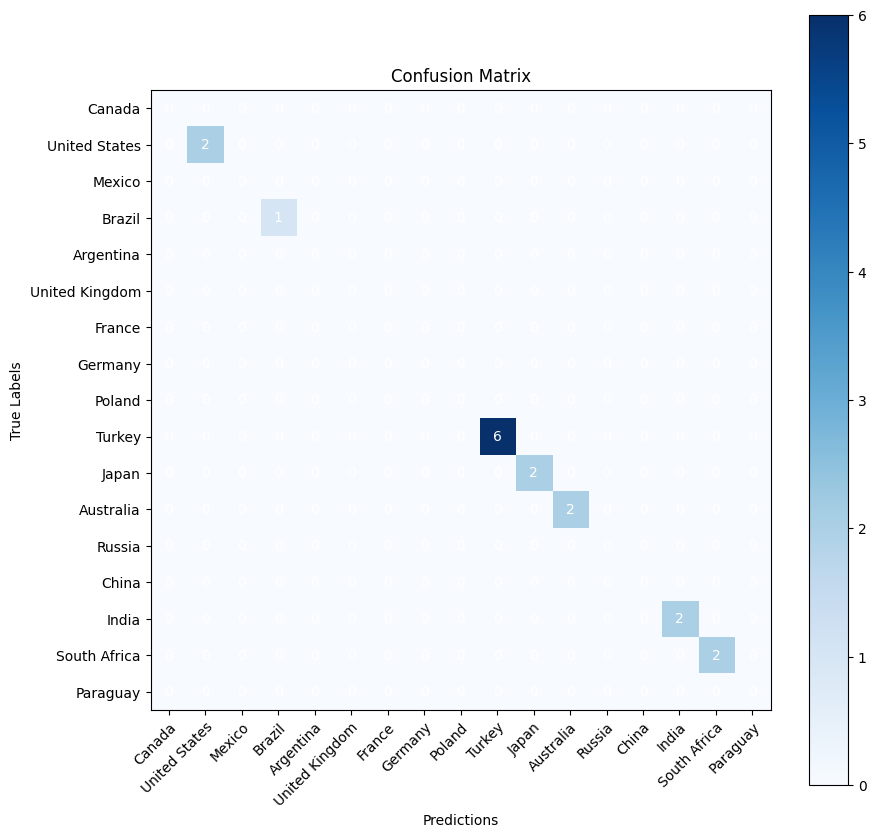

In [12]:
# Create the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
best_lstm.eval()

# Create variables to store predictions and ground truth labels
predictions = []
labels = []
# Loop through the test dataset and make predictions
for i, t in best_val_fold:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_label = idx2word[predicted_idx]
    label = t
    predictions.append(predicted_label)
    labels.append(label)

conf_mat = confusion_matrix(labels, predictions, labels=vocab)
# Print the confusion matrix
# print(np.array2string(conf_mat, separator=', '))

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(conf_mat, cmap='Blues')

# Set ticks for x and y axis
ax.set_xticks(np.arange(len(vocab)))
ax.set_yticks(np.arange(len(vocab)))

# Set labels for x and y axis
ax.set_xlabel('Predictions')
ax.set_ylabel('True Labels')
ax.set_xticklabels(vocab)
ax.set_yticklabels(vocab)

# Rotate the x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over the data and create annotations for each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")

# Set title and colorbar
ax.set_title("Confusion Matrix")
fig.colorbar(im)
plt.show()

Some specific expected model targets for their respective inputs:

In [13]:
# Test the model on a new input sequence
# inputs = df['inputs'].tolist() # A list of inputs. Example: [['United States', 'Japan', 'Australia'], ['Canada', 'United States', 'Mexico', 'Brazil'],  ['Canada', 'United States', 'United Kingdom', 'France', 'Germany', 'Poland'], ['Russia', 'China', 'India', 'Brazil'], and so on...]
# targets = df['targets'].tolist() # A list of targets for each input. Example: ['India', 'Argentina', 'Turkey', 'South Africa', and so on...]

input_seqs = [['Canada', 'United States', 'Mexico', 'Brazil'], ['Canada', 'United States', 'United Kingdom', 'France', 'Germany', 'Poland'], ['United States', 'Japan', 'Australia'], ['Russia', 'China', 'India', 'Brazil']]
for i in input_seqs:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_word = idx2word[predicted_idx]
    print(f'Input sequence: {i}, Predicted next word: {predicted_word}')

Input sequence: ['Canada', 'United States', 'Mexico', 'Brazil'], Predicted next word: Argentina
Input sequence: ['Canada', 'United States', 'United Kingdom', 'France', 'Germany', 'Poland'], Predicted next word: Turkey
Input sequence: ['United States', 'Japan', 'Australia'], Predicted next word: India
Input sequence: ['Russia', 'China', 'India', 'Brazil'], Predicted next word: South Africa


So the expected targets are hit when the model is given the right inputs. But what about other inputs?

In [14]:
input_seqs = [['Canada', 'United States', 'Mexico'], ['United Kingdom', 'France', 'Germany'], ['Japan', 'Australia'], ['Russia', 'China']]
for i in input_seqs:
    output = best_lstm(i)
    predicted_idx = torch.argmax(output[-1]).item()
    predicted_word = idx2word[predicted_idx]
    print(f'Input sequence: {i}, Predicted next word: {predicted_word}')
#Should expect: Brazil, Poland, India, and India again

Input sequence: ['Canada', 'United States', 'Mexico'], Predicted next word: Brazil
Input sequence: ['United Kingdom', 'France', 'Germany'], Predicted next word: Turkey
Input sequence: ['Japan', 'Australia'], Predicted next word: India
Input sequence: ['Russia', 'China'], Predicted next word: South Africa


As we can see, there's still work to do. We will see if we can fix this with more data or another model.